In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive/')

import sys

#-------------------------------------------------------------------#
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#-------------------------------------------------------------------#

Mounted at /content/gdrive/


# **Yearly Dataset**

I´ll treat the raw data by performing the following steps:


1.   Drop 1st row containing nothing but units
2.   Convert some columns to float, so i can do math on them
3.   Calculate flow rate in m³/d, producers: qo,qw,qg, and injectors: qwi, qgi
4.   Calculate RGO, BSW, WOR, LOR
5.   Eliminate rows having NULL for all of the following columns ['Oil','GI','WI'], which means the specific instance maps to a closed well.
6.   Drop columns where all values are NULL.












In [ ]:
# read  csv file
import io
uploaded = files.upload()
df=pd.read_csv(io.BytesIO(uploaded['production data.csv']),sep=";")
# drop first row containing units
df=df.drop(0)
# convert some cols to float
cols=['On Stream','Oil','Gas','Water','GI','WI']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
# calculate flow-rate in m³/d
rates=['qo','qw','qg','qwi','qgi']
cumulative=['Oil','Water','Gas','WI','GI']
for rate,cumul in zip(rates,cumulative):
  df[rate]=df[cumul]/(df['On Stream']/24)
# calculate liquid-rate
df['ql']=df['qo']+df['qw']
# calculate well RGO
df['rgo']=df['qg']/df['qo']
# calculate well BSW
df['bsw']=df['qw']/df['ql']
# eliminate wells that are closed:
# meaning a row has NULL
# for Oil, GI and WI simultaneously 
index=['Oil','GI','WI']
closed=df[index].isnull().all(1)
df.drop(df.index[closed], inplace=True)
# find columns where all values
# are NULL and get rid of them
cols_all_null=df.columns[df.isna().all()].tolist()
df.drop(cols_all_null,axis=1,inplace=True)

Saving production data.csv to production data.csv


In [ ]:
df.shape

(507, 16)

In [ ]:
print (df.dtypes)

Wellbore name     object
NPDCode          float64
Year             float64
Month            float64
On Stream        float64
Oil              float64
Gas              float64
Water            float64
WI               float64
qo               float64
qw               float64
qg               float64
qwi              float64
ql               float64
rgo              float64
bsw              float64
dtype: object


Notice GI column was dropped, revealing that gas has never been injected in this field.

In [ ]:
df.head()

,Wellbore name,NPDCode,Year,Month,On Stream,Oil,Gas,Water,WI,qo,qw,qg,qwi,ql,rgo,bsw
1,15/9-F-1 C,7405.0,2014.0,4.0,228.0,11142.0,1597937.0,0.0,NaN,1172.842105,0.000000,168203.894737,NaN,1172.842105,143.415635,0.000000
2,15/9-F-1 C,7405.0,2014.0,5.0,734.0,24902.0,3496230.0,783.0,NaN,814.234332,25.602180,114318.147139,NaN,839.836512,140.399566,0.030485
3,15/9-F-1 C,7405.0,2014.0,6.0,706.0,19618.0,2886662.0,2068.0,NaN,666.900850,70.300283,98130.152975,NaN,737.201133,147.143542,0.095361
4,15/9-F-1 C,7405.0,2014.0,7.0,742.0,15086.0,2249366.0,6244.0,NaN,487.956873,201.962264,72755.773585,NaN,689.919137,149.102877,0.292733
5,15/9-F-1 C,7405.0,2014.0,8.0,433.0,6970.0,1048191.0,4530.0,NaN,386.327945,251.085450,58098.346420,NaN,637.413395,150.386083,0.393913


In [ ]:
df.shape

(507, 16)

Let us first look at the aggregate field-level on a yearly basis

In [ ]:
# let us first look
# at the aggregate field-level data on a yearly basis
df_field_yearly=df.groupby(['Year'], as_index=False)['On Stream','Oil','Gas','Water','WI'].sum()
# calculate field flow-rate in m³/d
rates=['qo','qw','qg','qwi']
cumulative=['Oil','Water','Gas','WI']
for rate,cumul in zip(rates,cumulative):
  df_field_yearly[rate]=df_field_yearly[cumul]/(df_field_yearly['On Stream']/24)
# calculate field liquid-rate
df_field_yearly['ql']=df_field_yearly['qo']+df_field_yearly['qw']
# calculate field RGO
df_field_yearly['rgo']=df_field_yearly['qg']/df_field_yearly['qo']
# calculate field BSW
df_field_yearly['bsw']=df_field_yearly['qw']/df_field_yearly['ql']
# calculate field ROB
df_field_yearly['lor']=df_field_yearly['qo']/df_field_yearly['ql']
# calculate field RAO
df_field_yearly['wor']=df_field_yearly['qwi']/df_field_yearly['qo']
# calculate field Np
df_field_yearly['Np'] = df_field_yearly['Oil'].cumsum()
# calculate field Wp
df_field_yearly['Wp'] = df_field_yearly['Water'].cumsum()
# calculate field Gp
df_field_yearly['Gp'] = df_field_yearly['Gas'].cumsum()
# calculate field Wi
df_field_yearly['Wi'] = df_field_yearly['WI'].cumsum()

In [ ]:
df_field_yearly.head()

,Year,On Stream,Oil,Gas,Water,WI,qo,qw,qg,qwi,ql,rgo,bsw,lor,wor,Np,Wp,Gp,Wi
0,2008.0,19068.0,1764375.0,257038586.0,23508.0,2417769.0,2220.736312,29.588420,323522.449339,3043.132788,2250.324733,145.682514,0.013149,0.986851,1.370326,1764375.0,23508.0,2.570386e+08,2417769.0
1,2009.0,30891.0,2684394.0,375982012.0,232102.0,4392196.0,2085.573662,180.325920,292109.944256,3412.408274,2265.899582,140.062156,0.079582,0.920418,1.636196,4448769.0,255610.0,6.330206e+08,6809965.0
2,2010.0,31981.0,1689902.0,243948373.0,1887594.0,4569393.0,1268.179482,1416.536569,183069.977549,3429.080767,2684.716050,144.356521,0.527630,0.472370,2.703940,6138671.0,2143204.0,8.769690e+08,11379358.0
3,2011.0,26968.0,847964.0,130320196.0,2190641.0,3442448.0,754.640166,1949.547019,115977.629190,3063.584693,2704.187185,153.686001,0.720936,0.279064,4.059663,6986635.0,4333845.0,1.007289e+09,14821806.0
4,2012.0,28220.0,574208.0,90208642.0,2109599.0,2975213.0,488.341318,1794.130971,76718.901772,2530.301630,2282.472289,157.100984,0.786047,0.213953,5.181420,7560843.0,6443444.0,1.097498e+09,17797019.0


# **Yearly Dataset**

Time-series plots.

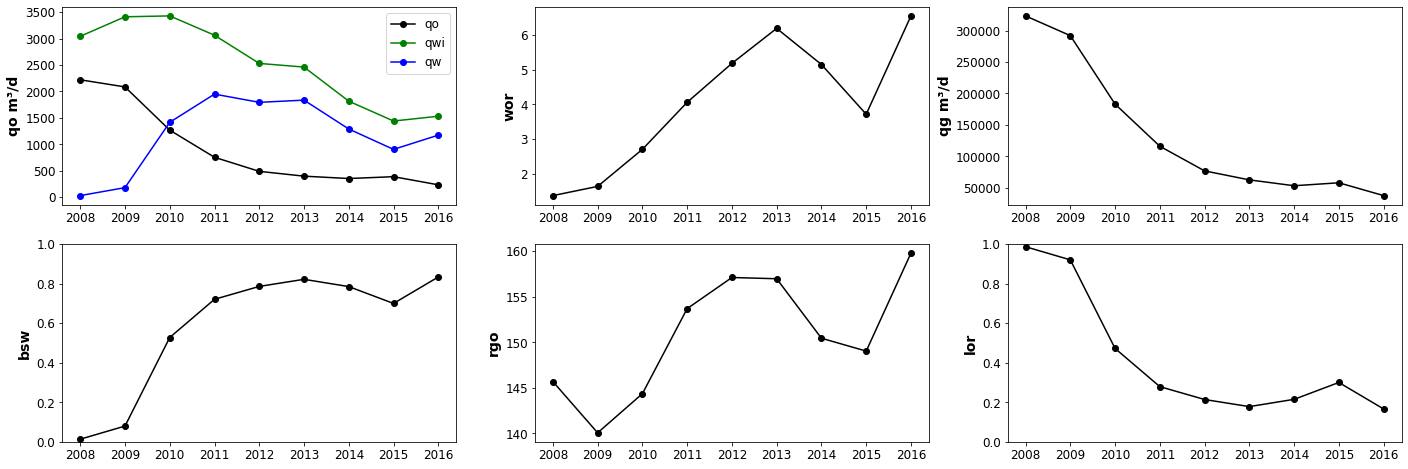

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_field_yearly['Year'],df_field_yearly['qo']/df_field_yearly[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_field_yearly['Year'],df_field_yearly[label],'ko-',label=legend)
    plt.plot(df_field_yearly['Year'],df_field_yearly['qwi'],'go-',label='qwi')
    plt.plot(df_field_yearly['Year'],df_field_yearly['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_field_yearly['Year'],df_field_yearly[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0)  


What can we learn from the time-series plots?

*   Dataset comprises 9 year-worth of production data, spanning the years from 2008 to 2016.
*   Initial oil-rate was around 2000 m³/d and it stands now at less
 than 500 m³/d. Production has plateaued at around 500 m³/d since 2012,
 despite the decline in water injection over the same period.
*   Water is injected in this field, gas has never been injected.
*   Water injection begun shortly after production. This indicates that there must not be an aquifer to rely on for pressure support. 
*   Water injection rate declines by around 50% over the course of 9 years. Why is that? Maybe they intentionally reduced injection rate, so as to stabilize BSW or maybe it was a loss in injectivity? 
*   As already mentioned, between years 2012 and 2016, water injection dropped from ~ 2500 m³/d to ~1500 m³/d, a 40% decline. However, oil-rate remained at around 500 m³/d. Maybe new producers were added?
*   In less that 2 years after the onset of water injection, BSW crossed over 50%. It stands now at around 90%!
*   According to Kubota et al. (2019a,b), looking at the LOR plot, we can infer that new producers were added in this field beggining in 2013. The addition of those new wells caused LOR to flatten out and even rise up a bit, otherwise it´d keep on coming down, as explained in Kubota et al.(2019a,b). That might explain  why, despite the 40% drop in water injection, the oil-rate has managed to remain virtually the same since 2012.
*   It is rather troubling, however, that in 2016 LOR has nose-dived once again. It is possible that the effect of new producers is wearing off. From then on, if no more producers are added, LOR curve will carry on its downward trajectory. Oil-rate will then keep on declining.
*   Since the effect of new producers is already wearing off, they were probably drilled in the same reservoir compartment, or the field is fairly homogeneous. As a result, their initial rate wasn't much different from the oil-rate from neighbouring wells.
*   Looking at RGO, we may infer that we´re dealing with a black-oil reservoir. RSi might be around 150.
*   Declining gas rate also suggest that, despite the reduction in water injection over time, average pressure must have remained somewhat stable during this time period. We are probably not dealing with a large field. Has average pressure dropped continuously, I would expect increasing gas rates. Water-injection alone was enough to provide pressure support. 
*   Looking at gas rates, reservoir average pressure must have remained above bubble pressure at all times. So secondary or primary gas caps can be ruled out.     
   

Our analysis so far has suggested there´s no aquifer and no gas-cap. Moreover, the average pressure didnt change much. As a result, from a Material Balance perspective we can write that: 

$N_p$$B_o$+$W_p$$B_w$+$G_p$$B_g$=$W_i$$B_w$

Notice the RHS only contains a single source of energy. As water-influx, gas-cap and the effect of reservoir compressibility can be ignored.

The plot below allows us to infer that Bo=1.45 (in line with black-oil), if we assume Bw=1.0 and Bg=0.001. 

Text(0, 0.5, 'NpBo+WpBw+GpBg')

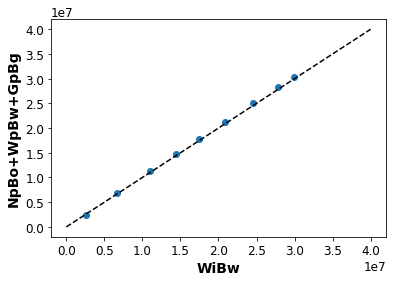

In [ ]:
plt.plot(df_field_yearly.Np*1.45+df_field_yearly.Wp*1.0+df_field_yearly.Wp*0.001,df_field_yearly.Wi,'o')
plt.plot([0,4e7],[0,4e7],'k--')
plt.xlabel("WiBw")
plt.ylabel("NpBo+WpBw+GpBg")

**Cross-plots.** 

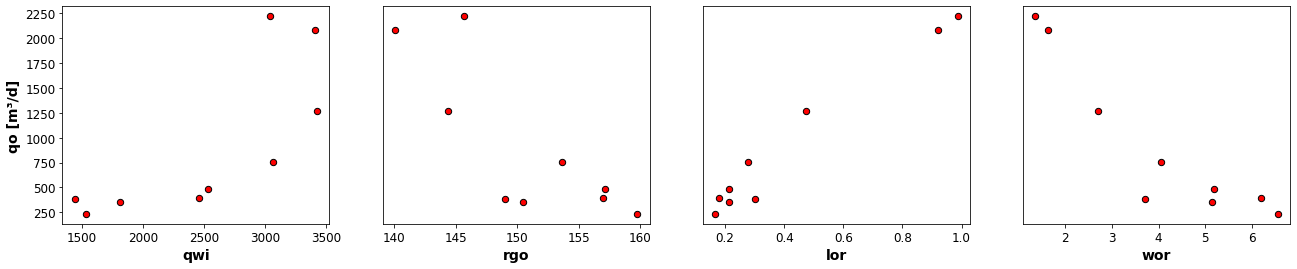

In [ ]:
# let´s see how 'qo'
# correlates with some 
# candidate features
features=['qwi','rgo','lor','wor']
subplots=(141,142,143,144)
plt.figure(figsize=(22,4))
for feat,subplot in zip(features,subplots):
  plt.subplot(subplot)
  plt.scatter(df_field_yearly[feat],df_field_yearly['qo'],s=40,edgecolors='k',c="r")
  if subplot==141:
    plt.ylabel('qo [m³/d]')
    plt.xlabel(feat)  
  else:  
    plt.xlabel(feat)
    plt.yticks([])  

In line with the results from Kubota et al.(2019a,b), there seems to be a correlation between qo vs qwi, and qo vs LOR. As pointed out in this article, LOR is much easier to forecast than either RGO or WOR, which is why it should be favored as a potential member of the feature-space for oil-rate prediction. Notice the relationship between qo vs qwi can be described by a linear model, if we are willing to ignore the initial production period. Otherwise, a non-linear model should be used instead.


**Injection yield and Rp.** 

(120.0, 160.0)

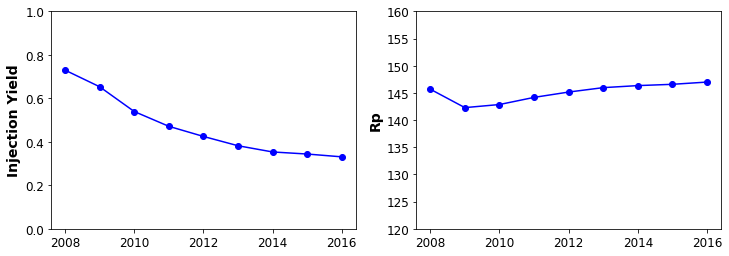

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(df_field_yearly['Year'],df_field_yearly['Np']/df_field_yearly['Wi'],'bo-',label='Np/Wi')
plt.ylabel("Injection Yield")
plt.ylim(0,1.0)
plt.subplot(122)
plt.plot(df_field_yearly['Year'],(df_field_yearly['Gp']/df_field_yearly['Np']),'bo-')
plt.ylabel("Rp")
plt.ylim(120,160)

Derived from cumulative production data, injection yield is defined as the ratio Np/Wi. This quantity can be easily derived from the fractional flow curve, and it is expected to continously decline over the course of water injection, as each additional $m^3$ of injected water yields less and less $m^3$ of oil. Also the Rp=Gp/Np curve suggests that Rsi is probably around 145, as speculated earlier.

# **Monthly Dataset**

In [ ]:
# let us first look
# at the aggregate field-level data on a yearly basis
df_field_monthly=df.groupby(['Year','Month'], as_index=False)['On Stream','Oil','Gas','Water','WI'].sum()
# calculate field flow-rate in m³/d
rates=['qo','qw','qg','qwi']
cumulative=['Oil','Water','Gas','WI']
for rate,cumul in zip(rates,cumulative):
  df_field_monthly[rate]=df_field_monthly[cumul]/(df_field_monthly['On Stream']/24)
# obtain number of rows
n_rows=len(df_field_monthly.index.to_list())
# create array of running months
months=np.arange(1,n_rows+1)
df_field_monthly['t_months']=months
# calculate field liquid-rate
df_field_monthly['ql']=df_field_monthly['qo']+df_field_monthly['qw']
# calculate field RGO
df_field_monthly['rgo']=df_field_monthly['qg']/df_field_monthly['qo']
# calculate field BSW
df_field_monthly['bsw']=df_field_monthly['qw']/df_field_monthly['ql']
# calculate field ROB
df_field_monthly['lor']=df_field_monthly['qo']/df_field_monthly['ql']
# calculate field RAO
df_field_monthly['wor']=df_field_monthly['qwi']/df_field_monthly['qo']
# calculate field Np
df_field_monthly['Np'] = df_field_monthly['Oil'].cumsum()
# calculate field Wp
df_field_monthly['Wp'] = df_field_monthly['Water'].cumsum()
# calculate field Gp
df_field_monthly['Gp'] = df_field_monthly['Gas'].cumsum()
# calculate field Wi
df_field_monthly['Wi'] = df_field_monthly['WI'].cumsum()

In [ ]:
df_field_monthly.head()

,Year,Month,On Stream,Oil,Gas,Water,WI,qo,qw,qg,qwi,t_months,ql,rgo,bsw,lor,wor,Np,Wp,Gp,Wi
0,2008.0,2.0,407.0,49091.0,7068009.0,413.0,0.0,2894.800983,24.353808,416786.771499,0.000000,1,2919.154791,143.977694,0.008343,0.991657,0.000000,49091.0,413.0,7068009.0,0.0
1,2008.0,3.0,655.0,83361.0,12191171.0,27.0,0.0,3054.448855,0.989313,446699.395420,0.000000,2,3055.438168,146.245498,0.000324,0.999676,0.000000,132452.0,440.0,19259180.0,0.0
2,2008.0,4.0,733.0,74532.0,11506441.0,482.0,29753.0,2440.338336,15.781719,376745.680764,974.177353,3,2456.120055,154.382561,0.006425,0.993575,0.399198,206984.0,922.0,30765621.0,29753.0
3,2008.0,5.0,1430.0,125479.0,19091872.0,16280.0,221337.0,2105.941259,273.230769,320423.026573,3714.746853,4,2379.172028,152.151930,0.114843,0.885157,1.763937,332463.0,17202.0,49857493.0,251090.0
4,2008.0,6.0,1275.0,143787.0,21512334.0,474.0,211804.0,2706.578824,8.922353,404938.051765,3986.898824,5,2715.501176,149.612510,0.003286,0.996714,1.473040,476250.0,17676.0,71369827.0,462894.0


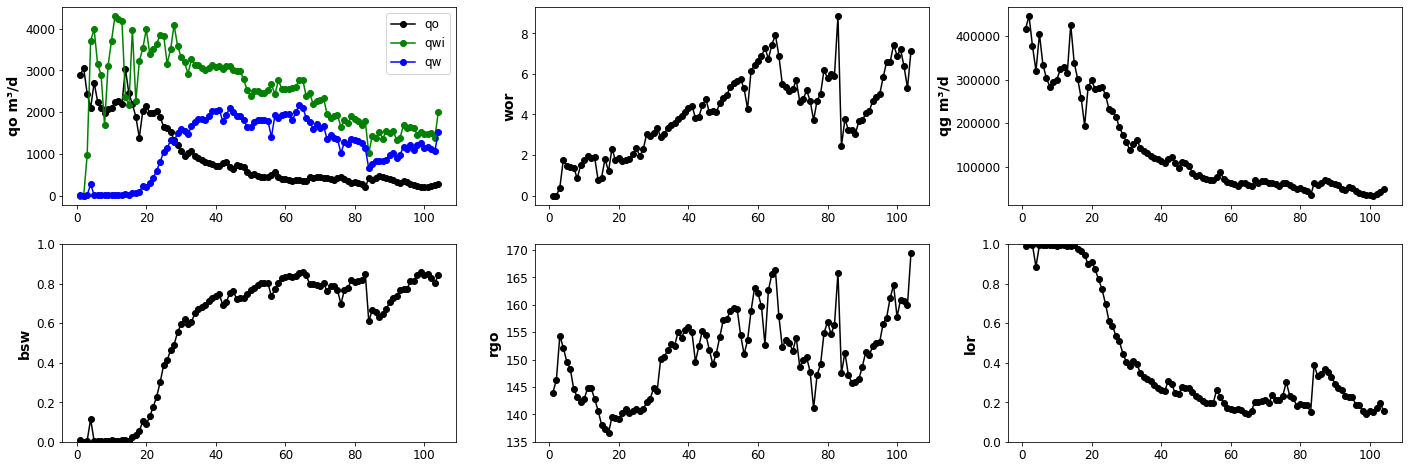

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_field_monthly['t_months'],df_field_monthly['qo']/df_field_monthly[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_field_monthly['t_months'],df_field_monthly[label],'ko-',label=legend)
    plt.plot(df_field_monthly['t_months'],df_field_monthly['qwi'],'go-',label='qwi')
    plt.plot(df_field_monthly['t_months'],df_field_monthly['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_field_monthly['t_months'],df_field_monthly[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0)  


The monthly time-frame allows us to zoom in on some behaviors, despite its inherent noiseness, such as:


*   Water break-through started shortly before 20 months.
*   LOR stabilizes after around 60 months, when new producers were probably added.
*   Notice how RGO and WOR are much noisier than LOR. According Kubota (2019a,b), in the absence of new wells, LOR will inevitably decline. First exponentially, then linearly. As a result, LOR serves as less noisy predictor than either RGO or WOR.



**Cross-plots.**

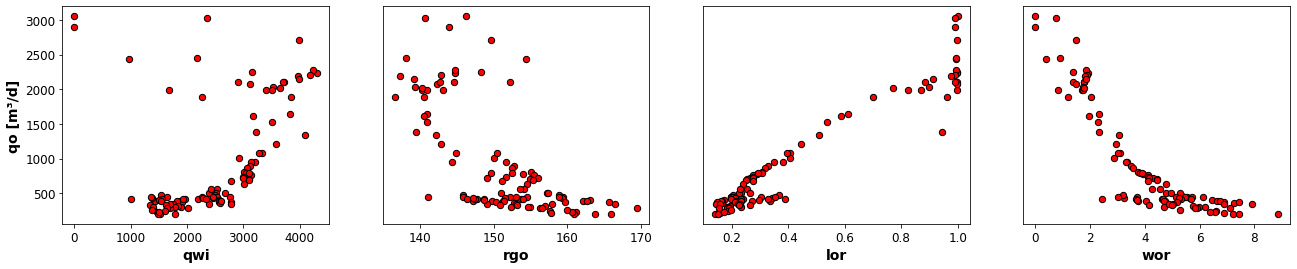

In [ ]:
# let´s see how 'qo'
# correlates with some 
# candidate features
features=['qwi','rgo','lor','wor']
subplots=(141,142,143,144)
plt.figure(figsize=(22,4))
for feat,subplot in zip(features,subplots):
  plt.subplot(subplot)
  plt.scatter(df_field_monthly[feat],df_field_monthly['qo'],s=40,edgecolors='k',c="r")
  if subplot==141:
    plt.ylabel('qo [m³/d]')
    plt.xlabel(feat)  
  else:  
    plt.xlabel(feat)
    plt.yticks([]) 

The monthly cross-plots suggest that full-field monthly oil production using ML algorithms will require non-linear models if qwi and lor are to be used as features.  

(130.0, 160.0)

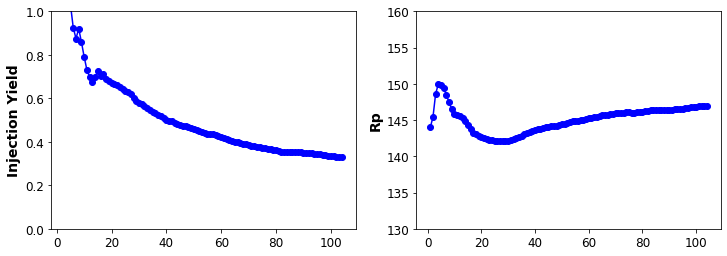

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(df_field_monthly['t_months'],df_field_monthly['Np']/df_field_monthly['Wi'],'bo-',label='Np/Wi')
plt.ylabel("Injection Yield")
plt.ylim(0,1.0)
plt.subplot(122)
plt.plot(df_field_monthly['t_months'],(df_field_monthly['Gp']/df_field_monthly['Np']),'bo-')
plt.ylabel("Rp")
plt.ylim(130,160)

Derived from cumulative production data, injection yield is defined as the ratio Np/Wi. This quantity can be easily derived from the fractional flow curve, and it is expected to continously decline over the course of water injection, as each additional $m^3$ of injected water yields less and less $m^3$ of oil. Also the Rp=Gp/Np curve suggests Rsi is probably around 145, as speculated earlier.

# **Producers and Injectors**

what´s NPD Code? Maybe it´s a well code?

In [ ]:
# what´s NPD Code? Maybe it´s 
# a well code?
len(df['Wellbore name'].unique())==len(df['NPDCode'].unique())
print(f"There are {len(df['Wellbore name'].unique())} different wells")

There are 7 different wells


**More data processing.** So let´s aggregate by Year and Well and create a new dataframe.Next let´s define the well type for each well.

In [ ]:
# so let´s aggregate by Year and Well
# and create a new dataframe
df_wells_yearly=df.groupby(['Year','NPDCode'], as_index=False)['On Stream','Oil','Gas','Water','WI'].sum()
df_wells_yearly.head()
# next let´s define the
# well type for each well
producer_rows=(df_wells_yearly['Oil']>0) & (df_wells_yearly['WI']==0)
df_wells_yearly["WellsType"]="P"
df_wells_yearly["WellsType"][producer_rows]="producer"
injector_rows=(df_wells_yearly['Oil']==0) & (df_wells_yearly['WI']>0)
df_wells_yearly["WellsType"][injector_rows]="injector"
trans_rows=(df_wells_yearly['Oil']>0) & (df_wells_yearly['WI']>0)
df_wells_yearly["WellsType"][trans_rows]="trans"
df_wells_yearly.head()

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType
0,2008.0,5351.0,3744.0,590928.0,84849047.0,983.0,0.0,producer
1,2008.0,5599.0,7215.0,1173447.0,172189539.0,22525.0,0.0,producer
2,2008.0,5693.0,5431.0,0.0,0.0,0.0,1726241.0,injector
3,2008.0,5769.0,2678.0,0.0,0.0,0.0,691528.0,injector
4,2009.0,5351.0,7798.0,1161852.0,162976873.0,178732.0,0.0,producer


In [ ]:
# calculate flow-rate in m³/d
rates=['qo','qw','qg','qwi']
cumulative=['Oil','Water','Gas','WI']
for rate,cumul in zip(rates,cumulative):
  df_wells_yearly[rate]=df_wells_yearly[cumul]/(df_wells_yearly['On Stream']/24)
# calculate liquid-rate
df_wells_yearly['ql']=df_wells_yearly['qo']+df_wells_yearly['qw']
# calculate well RGO
df_wells_yearly['rgo']=df_wells_yearly['qg']/df_wells_yearly['qo']
# calculate well BSW
df_wells_yearly['bsw']=df_wells_yearly['qw']/df_wells_yearly['ql']
# calculate well RAO
df_wells_yearly['wor']=df_wells_yearly['qw']/df_wells_yearly['qo']
df_wells_yearly.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
0,2008.0,5351.0,3744.0,590928.0,84849047.0,983.0,0.0,producer,3788.000000,6.301282,543904.147436,0.000000,3794.301282,143.586100,0.001661,0.001663
1,2008.0,5599.0,7215.0,1173447.0,172189539.0,22525.0,0.0,producer,3903.358004,74.927235,572771.855301,0.000000,3978.285239,146.738233,0.018834,0.019196
2,2008.0,5693.0,5431.0,0.0,0.0,0.0,1726241.0,injector,0.000000,0.000000,0.000000,7628.389615,0.000000,NaN,NaN,NaN
3,2008.0,5769.0,2678.0,0.0,0.0,0.0,691528.0,injector,0.000000,0.000000,0.000000,6197.412995,0.000000,NaN,NaN,NaN
4,2009.0,5351.0,7798.0,1161852.0,162976873.0,178732.0,0.0,producer,3575.846114,550.085663,501595.915876,0.000000,4125.931777,140.273351,0.133324,0.153834
5,2009.0,5599.0,7975.0,1522542.0,213005139.0,53370.0,0.0,producer,4581.944577,160.611912,641018.600125,0.000000,4742.556489,139.900994,0.033866,0.035053
6,2009.0,5693.0,7556.0,0.0,0.0,0.0,2149477.0,injector,0.000000,0.000000,0.000000,6827.348862,0.000000,NaN,NaN,NaN
7,2009.0,5769.0,7562.0,0.0,0.0,0.0,2242719.0,injector,0.000000,0.000000,0.000000,7117.859825,0.000000,NaN,NaN,NaN
8,2010.0,5351.0,8045.0,816073.0,118249392.0,982061.0,0.0,producer,2434.524798,2929.703418,352763.879180,0.000000,5364.228216,144.900508,0.546156,1.203398
9,2010.0,5599.0,8143.0,873829.0,125698981.0,905533.0,0.0,producer,2575.450817,2668.892546,370474.707602,0.000000,5244.343362,143.848489,0.508909,1.036282


Let´s see if injectors were on since the very beggining

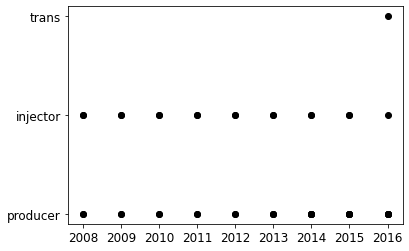

In [ ]:
# let´s see if injectors
# were on since
# the very beggining
plt.plot(df_wells_yearly['Year'],df_wells_yearly['WellsType'],'ko')
# a conversion happened in 2016

Notice a well conversion happened in 2016. Was it P2I or I2P?

Let´s see how the number of wells changed overtime.
According to the LOR, in 2013 new producers were added
let´s see if LOR is correct.

Text(0, 0.5, 'NPDCode')

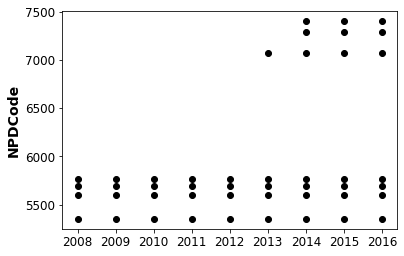

In [ ]:
# let´s see how the number of wells
# changed overtime
# according to the ROB, in 2014 new producers were added
# let´s see if ROB is correct
plt.plot(df_wells_yearly['Year'],df_wells_yearly['NPDCode'],'ko')
plt.ylabel("NPDCode")
# it is indeed!! In 2014 2 producers were added!
# and in 2013, 1 was added.
# the wells with NPDCode 7XXX are the new producers

It is indeed!! In 2014 2 producers were added! And in 2013, 1 was added.
The wells with NPDCode 7XXX are the new producers

Now let´s see which one are injectors and which one got converted

Text(0, 0.5, 'NPD Code')

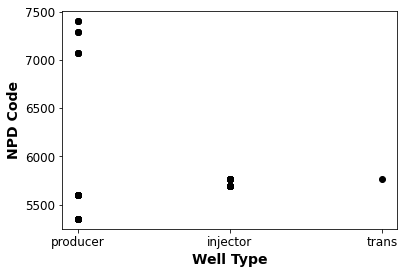

In [ ]:
# now let´s see which one are injectors
# and which one got converted
plt.plot(df_wells_yearly['WellsType'],df_wells_yearly['NPDCode'],'ko')
plt.xlabel("Well Type")
plt.ylabel("NPD Code")
# okay, so now we know the field begun
# with 4 wells (2P,2I), in 2013 1P was added.
# And in 2014 2P were added.
# Finally, in 2016 there was a conversion
# where an injector became a producer
# So 2016 features
# only 1 injector and 6 producers(=5 original+1trans)

Okay, so now we know the field begun with 4 wells (2P,2I), in 2013 1P was added.
And in 2014 2P were added. Finally, in 2016 there was a conversion
where an injector became a producer.
So 2016 features only 1 injector and 6 producers(=5 original+1trans)

Let´s confirm our conclusions

In [ ]:
# let´s confirm our conclusions
df_wells_yearly.loc[(df_wells_yearly['Year'].eq(2016)) & (df_wells_yearly['WellsType'].isin(["producer"]))]
# we have 5 producers

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
39,2016.0,5351.0,4641.0,23029.0,3679358.0,589250.0,0.0,producer,119.089851,3047.188106,19027.061409,0.0,3166.277957,159.770637,0.962388,25.587303
40,2016.0,5599.0,5328.0,47900.0,7651741.0,263489.0,0.0,producer,215.765766,1186.887387,34467.301802,0.0,1402.653153,159.744071,0.846173,5.500814
43,2016.0,7078.0,6092.0,163709.0,26179173.0,625930.0,0.0,producer,644.946815,2465.909389,103135.284307,0.0,3110.856205,159.912851,0.792679,3.823431
44,2016.0,7289.0,3593.0,25284.0,4031973.0,32830.0,0.0,producer,168.888394,219.293070,26932.188144,0.0,388.181464,159.467371,0.564924,1.298450
45,2016.0,7405.0,1370.0,12289.0,1965059.0,47834.0,0.0,producer,215.281752,837.967883,34424.391241,0.0,1053.249635,159.903898,0.795602,3.892424


In [ ]:
# let´s confirm our conclusions
df_wells_yearly.loc[(df_wells_yearly['Year'].eq(2016)) & (df_wells_yearly['WellsType'].isin(["injector"]))]
# we have only 1 injector!

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
41,2016.0,5693.0,5918.0,0.0,0.0,0.0,1579608.0,injector,0.0,0.0,0.0,6405.980399,0.0,NaN,NaN,NaN


# **Today**

Let´s cutout today´s dataframe

In [ ]:
# let´s cutout today´s dataframe
df_today=df_wells_yearly.loc[(df_wells_yearly['Year'].eq(2016)) & (df_wells_yearly['WellsType'].isin(["producer","trans","injector"]))]
df_today.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
39,2016.0,5351.0,4641.0,23029.0,3679358.0,589250.0,0.0,producer,119.089851,3047.188106,19027.061409,0.000000,3166.277957,159.770637,0.962388,25.587303
40,2016.0,5599.0,5328.0,47900.0,7651741.0,263489.0,0.0,producer,215.765766,1186.887387,34467.301802,0.000000,1402.653153,159.744071,0.846173,5.500814
41,2016.0,5693.0,5918.0,0.0,0.0,0.0,1579608.0,injector,0.000000,0.000000,0.000000,6405.980399,0.000000,NaN,NaN,NaN
42,2016.0,5769.0,5227.0,41160.0,6561826.0,13534.0,472622.0,trans,188.987947,62.141955,30128.912187,2170.064664,251.129902,159.422400,0.247449,0.328814
43,2016.0,7078.0,6092.0,163709.0,26179173.0,625930.0,0.0,producer,644.946815,2465.909389,103135.284307,0.000000,3110.856205,159.912851,0.792679,3.823431
44,2016.0,7289.0,3593.0,25284.0,4031973.0,32830.0,0.0,producer,168.888394,219.293070,26932.188144,0.000000,388.181464,159.467371,0.564924,1.298450
45,2016.0,7405.0,1370.0,12289.0,1965059.0,47834.0,0.0,producer,215.281752,837.967883,34424.391241,0.000000,1053.249635,159.903898,0.795602,3.892424


Well 5769 was the one that got converted.Well 5693 is the only injector left.

In [ ]:
# calculate flow-rate in m³/d
rates=['qo','qw','qg','qwi']
cumulative=['Oil','Water','Gas','WI']
for rate,cumul in zip(rates,cumulative):
  df_today[rate]=df_today[cumul]/(df_today['On Stream']/24)
# calculate liquid-rate
df_today['ql']=df_today['qo']+df_today['qw']
# calculate well RGO
df_today['rgo']=df_today['qg']/df_today['qo']
# calculate well BSW
df_today['bsw']=df_today['qw']/df_today['ql']
df_today.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
39,2016.0,5351.0,4641.0,23029.0,3679358.0,589250.0,0.0,producer,119.089851,3047.188106,19027.061409,0.000000,3166.277957,159.770637,0.962388,25.587303
40,2016.0,5599.0,5328.0,47900.0,7651741.0,263489.0,0.0,producer,215.765766,1186.887387,34467.301802,0.000000,1402.653153,159.744071,0.846173,5.500814
41,2016.0,5693.0,5918.0,0.0,0.0,0.0,1579608.0,injector,0.000000,0.000000,0.000000,6405.980399,0.000000,NaN,NaN,NaN
42,2016.0,5769.0,5227.0,41160.0,6561826.0,13534.0,472622.0,trans,188.987947,62.141955,30128.912187,2170.064664,251.129902,159.422400,0.247449,0.328814
43,2016.0,7078.0,6092.0,163709.0,26179173.0,625930.0,0.0,producer,644.946815,2465.909389,103135.284307,0.000000,3110.856205,159.912851,0.792679,3.823431
44,2016.0,7289.0,3593.0,25284.0,4031973.0,32830.0,0.0,producer,168.888394,219.293070,26932.188144,0.000000,388.181464,159.467371,0.564924,1.298450
45,2016.0,7405.0,1370.0,12289.0,1965059.0,47834.0,0.0,producer,215.281752,837.967883,34424.391241,0.000000,1053.249635,159.903898,0.795602,3.892424


Let´s see which wells in 2016 feature the highest and lowest flow-rate.

Text(0, 0.5, 'NPDCode')

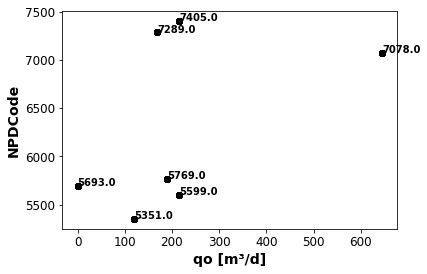

In [ ]:
for index,rate in enumerate(df_today["qo"]):
  plt.plot(df_today["qo"],df_today["NPDCode"],"ko")
  plt.text(df_today["qo"].iloc[index], df_today["NPDCode"].iloc[index], str(df_today["NPDCode"].iloc[index]), fontdict={"weight": "bold", "size": 10})
plt.xlabel("qo [m³/d]")
plt.ylabel("NPDCode")  

* Top oil-rate: 7078
* Lowest oil-rate: 5351
* The only injector left: 5693

Let´s see which wells in 2016 feature the highest and lowest BSW.

Text(0, 0.5, 'NPDCode')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


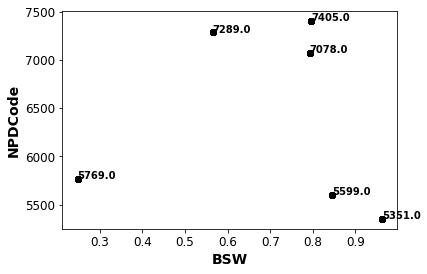

In [ ]:
for index,rate in enumerate(df_today["NPDCode"]):
  plt.plot(df_today["bsw"],df_today["NPDCode"],"ko")
  plt.text(df_today["bsw"].iloc[index], df_today["NPDCode"].iloc[index], str(df_today["NPDCode"].iloc[index]), fontdict={"weight": "bold", "size": 10})
plt.xlabel("BSW")
plt.ylabel("NPDCode")

* Highest BSW: 5351
* Lowest BSW: 5769 (but this is the one that got converted) and 7289 (this one is new)
* Notice the wells 7405 and 7078, despite being new wells, both feature 80% BSW!

Text(0, 0.5, 'NPDCode')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


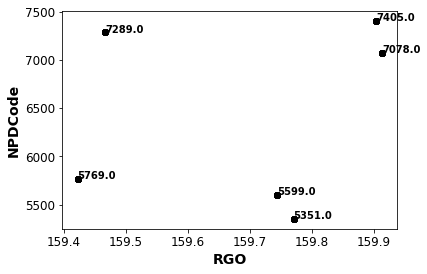

In [ ]:
for index,rate in enumerate(df_today["NPDCode"]):
  plt.plot(df_today["rgo"],df_today["NPDCode"],"ko")
  plt.text(df_today["rgo"].iloc[index], df_today["NPDCode"].iloc[index], str(df_today["NPDCode"].iloc[index]), fontdict={"weight": "bold", "size": 10})
plt.xlabel("RGO")
plt.ylabel("NPDCode")

RGO is virtually the same for all wells in 2016!

Let´s see which wells have been on the longest.

In [ ]:
df_wells_lifetime=df_wells_yearly.groupby(['NPDCode'], as_index=False)['On Stream'].sum()
df_wells_lifetime['On Stream (days)']=df_wells_lifetime['On Stream']/24
df_wells_lifetime.head(10)

,NPDCode,On Stream,On Stream (days)
0,5351.0,62778.0,2615.750000
1,5599.0,65204.0,2716.833333
2,5693.0,64271.0,2677.958333
3,5769.0,60827.0,2534.458333
4,7078.0,26006.0,1083.583333
5,7289.0,17823.0,742.625000
6,7405.0,9984.0,416.000000


Top two would be well 5599 and 5351.

# **A closer look at well 5351 (lowest rate in 2016)**

In [ ]:
df_5351=df_wells_yearly.loc[(df_wells_yearly["NPDCode"].eq(5351))]
df_5351.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
0,2008.0,5351.0,3744.0,590928.0,84849047.0,983.0,0.0,producer,3788.000000,6.301282,543904.147436,0.0,3794.301282,143.586100,0.001661,0.001663
4,2009.0,5351.0,7798.0,1161852.0,162976873.0,178732.0,0.0,producer,3575.846114,550.085663,501595.915876,0.0,4125.931777,140.273351,0.133324,0.153834
8,2010.0,5351.0,8045.0,816073.0,118249392.0,982061.0,0.0,producer,2434.524798,2929.703418,352763.879180,0.0,5364.228216,144.900508,0.546156,1.203398
12,2011.0,5351.0,6806.0,508246.0,78476256.0,1130225.0,0.0,producer,1792.228034,3985.512783,276730.846900,0.0,5777.740817,154.406047,0.689805,2.223775
16,2012.0,5351.0,7075.0,348386.0,54179045.0,769848.0,0.0,producer,1181.804099,2611.498516,183787.573145,0.0,3793.302615,155.514415,0.688450,2.209756
20,2013.0,5351.0,7787.0,263760.0,41131830.0,1121458.0,0.0,producer,812.924104,3456.400668,126770.761526,0.0,4269.324772,155.944154,0.809590,4.251812
25,2014.0,5351.0,8290.0,151564.0,22745362.0,1200916.0,0.0,producer,438.786007,3476.717008,65849.057660,0.0,3915.503016,150.071006,0.887936,7.923491
32,2015.0,5351.0,8592.0,78396.0,11722379.0,1147773.0,0.0,producer,218.983240,3206.069832,32744.075419,0.0,3425.053073,149.527769,0.936064,14.640709
39,2016.0,5351.0,4641.0,23029.0,3679358.0,589250.0,0.0,producer,119.089851,3047.188106,19027.061409,0.0,3166.277957,159.770637,0.962388,25.587303


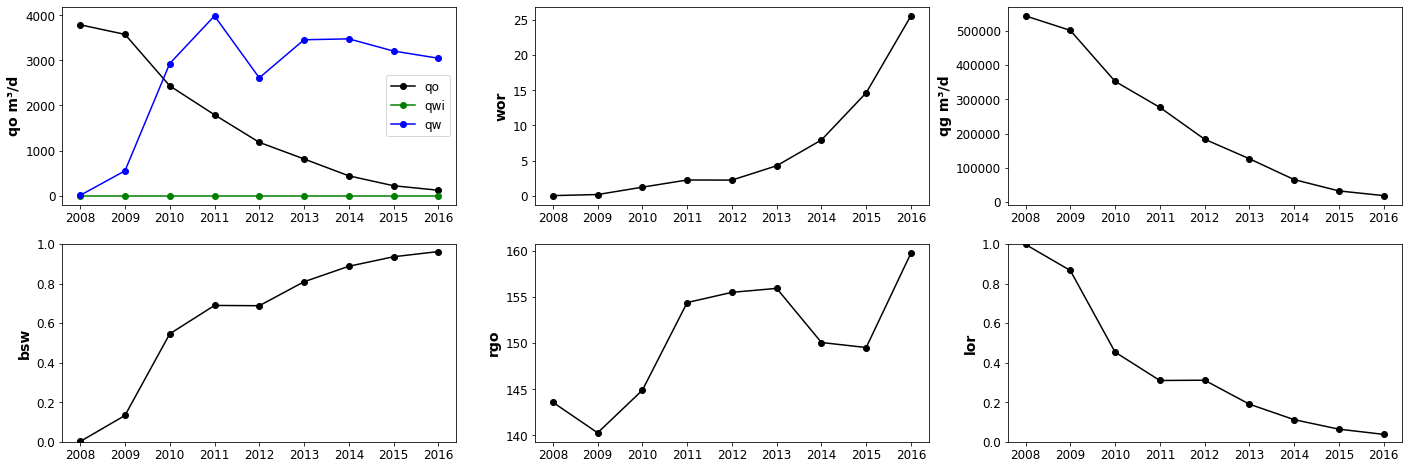

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_5351['Year'],df_5351['qo']/df_5351[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_5351['Year'],df_5351[label],'ko-',label=legend)
    plt.plot(df_5351['Year'],df_5351['qwi'],'go-',label='qwi')
    plt.plot(df_5351['Year'],df_5351['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_5351['Year'],df_5351[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0)  


# **A closer look at well 7078 (highest rate in 2016)**

In [ ]:
df_7078=df_wells_yearly.loc[(df_wells_yearly["NPDCode"].eq(7078))]
df_7078.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
24,2013.0,7078.0,3291.0,156101.0,24000890.0,12775.0,0.0,producer,1138.384686,93.163172,175029.279854,0.0,1231.547858,153.752314,0.075647,0.081838
29,2014.0,7078.0,8223.0,362225.0,54777201.0,70099.0,0.0,producer,1057.205399,204.593944,159875.085005,0.0,1261.799343,151.224242,0.162145,0.193523
36,2015.0,7078.0,8400.0,465818.0,69353255.0,382003.0,0.0,producer,1330.908571,1091.437143,198152.157143,0.0,2422.345714,148.884876,0.450570,0.820069
43,2016.0,7078.0,6092.0,163709.0,26179173.0,625930.0,0.0,producer,644.946815,2465.909389,103135.284307,0.0,3110.856205,159.912851,0.792679,3.823431


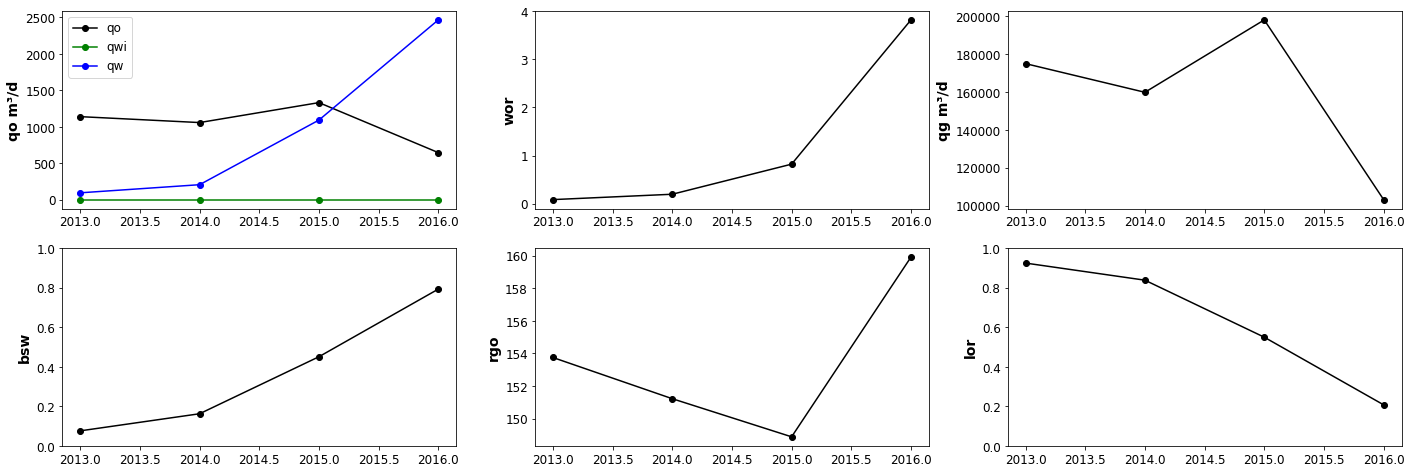

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_7078['Year'],df_7078['qo']/df_7078[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_7078['Year'],df_7078[label],'ko-',label=legend)
    plt.plot(df_7078['Year'],df_7078['qwi'],'go-',label='qwi')
    plt.plot(df_7078['Year'],df_7078['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_7078['Year'],df_7078[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0) 

In [ ]:
df_wells_lifetime=df_wells_yearly.groupby(['NPDCode'], as_index=False)['On Stream'].sum()
df_wells_lifetime['On Stream (days)']=df_wells_lifetime['On Stream']/24
df_wells_lifetime.head(10)

,NPDCode,On Stream,On Stream (days)
0,5351.0,62778.0,2615.750000
1,5599.0,65204.0,2716.833333
2,5693.0,64271.0,2677.958333
3,5769.0,60827.0,2534.458333
4,7078.0,26006.0,1083.583333
5,7289.0,17823.0,742.625000
6,7405.0,9984.0,416.000000


In [ ]:
df_wells_yearly_cumulative=df_wells_yearly.groupby(['NPDCode'], as_index=False)['On Stream','Oil','Gas','Water','WI'].sum()
df_wells_yearly_cumulative['avg oil rate']=df_wells_yearly_cumulative['Oil']/df_wells_yearly_cumulative['On Stream']
df_wells_yearly_cumulative.sort_values(by=['Oil'], ascending=False)


,NPDCode,On Stream,Oil,Gas,Water,WI,avg oil rate
1,5599.0,65204.0,4579613.0,667542277.0,6833318.0,0.0,70.235154
0,5351.0,62778.0,3942234.0,578009542.0,7121246.0,0.0,62.796425
4,7078.0,26006.0,1147853.0,174310519.0,1090807.0,0.0,44.138007
6,7405.0,9984.0,177709.0,26440919.0,207301.0,0.0,17.799379
5,7289.0,17823.0,148519.0,22505351.0,52369.0,0.0,8.332997
3,5769.0,60827.0,41160.0,6561826.0,13534.0,14089406.0,0.676673
2,5693.0,64271.0,0.0,0.0,0.0,16240727.0,0.000000


The table above shows the most and least prolific wells.

# **A closer look at well 5599 (most prolific well)**

In [ ]:
df_5599=df_wells_yearly.loc[(df_wells_yearly["NPDCode"].eq(5599))]
df_5599.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
1,2008.0,5599.0,7215.0,1173447.0,172189539.0,22525.0,0.0,producer,3903.358004,74.927235,572771.855301,0.0,3978.285239,146.738233,0.018834,0.019196
5,2009.0,5599.0,7975.0,1522542.0,213005139.0,53370.0,0.0,producer,4581.944577,160.611912,641018.600125,0.0,4742.556489,139.900994,0.033866,0.035053
9,2010.0,5599.0,8143.0,873829.0,125698981.0,905533.0,0.0,producer,2575.450817,2668.892546,370474.707602,0.0,5244.343362,143.848489,0.508909,1.036282
13,2011.0,5599.0,6761.0,339718.0,51843940.0,1060416.0,0.0,producer,1205.921018,3764.233693,184034.101464,0.0,4970.154711,152.608752,0.757368,3.121460
17,2012.0,5599.0,7078.0,225822.0,36029597.0,1339751.0,0.0,producer,765.714609,4542.812094,122168.738062,0.0,5308.526702,159.548658,0.855758,5.932774
21,2013.0,5599.0,7357.0,138155.0,22455058.0,1442132.0,0.0,producer,450.689140,4704.521952,73252.873726,0.0,5155.211091,162.535254,0.912576,10.438507
26,2014.0,5599.0,6880.0,57999.0,8830911.0,1404953.0,0.0,producer,202.322093,4900.998837,30805.503488,0.0,5103.320930,152.259711,0.960355,24.223745
33,2015.0,5599.0,8467.0,200201.0,29837371.0,341149.0,0.0,producer,567.476556,966.998465,84575.044762,0.0,1534.475021,149.037073,0.630182,1.704032
40,2016.0,5599.0,5328.0,47900.0,7651741.0,263489.0,0.0,producer,215.765766,1186.887387,34467.301802,0.0,1402.653153,159.744071,0.846173,5.500814


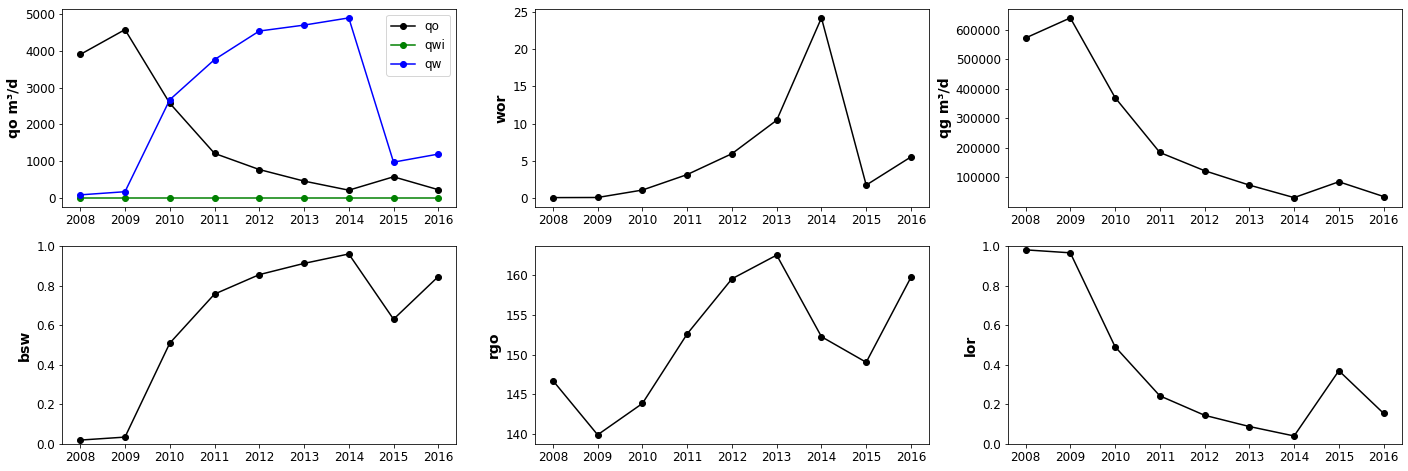

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_5599['Year'],df_5599['qo']/df_5599[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_5599['Year'],df_5599[label],'ko-',label=legend)
    plt.plot(df_5599['Year'],df_5599['qwi'],'go-',label='qwi')
    plt.plot(df_5599['Year'],df_5599['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_5599['Year'],df_5599[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0) 

Notice what happened in this well: the engineers probably shut-off a high-BSW zone in 2015. Or maybe a neighboring injector had its rate drastically changed? Let´s look at the injectors to find out!

# **A closer look at the injector 5693**

In [ ]:
df_5693=df_wells_yearly.loc[(df_wells_yearly["NPDCode"].eq(5693))]
df_5693.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
2,2008.0,5693.0,5431.0,0.0,0.0,0.0,1726241.0,injector,0.0,0.0,0.0,7628.389615,0.0,NaN,NaN,NaN
6,2009.0,5693.0,7556.0,0.0,0.0,0.0,2149477.0,injector,0.0,0.0,0.0,6827.348862,0.0,NaN,NaN,NaN
10,2010.0,5693.0,7941.0,0.0,0.0,0.0,2265470.0,injector,0.0,0.0,0.0,6846.905931,0.0,NaN,NaN,NaN
14,2011.0,5693.0,6677.0,0.0,0.0,0.0,1721152.0,injector,0.0,0.0,0.0,6186.558035,0.0,NaN,NaN,NaN
18,2012.0,5693.0,7010.0,0.0,0.0,0.0,1460918.0,injector,0.0,0.0,0.0,5001.716405,0.0,NaN,NaN,NaN
22,2013.0,5693.0,7667.0,0.0,0.0,0.0,1665162.0,injector,0.0,0.0,0.0,5212.454415,0.0,NaN,NaN,NaN
27,2014.0,5693.0,7655.0,0.0,0.0,0.0,2040384.0,injector,0.0,0.0,0.0,6397.023645,0.0,NaN,NaN,NaN
34,2015.0,5693.0,8416.0,0.0,0.0,0.0,1632315.0,injector,0.0,0.0,0.0,4654.890684,0.0,NaN,NaN,NaN
41,2016.0,5693.0,5918.0,0.0,0.0,0.0,1579608.0,injector,0.0,0.0,0.0,6405.980399,0.0,NaN,NaN,NaN


(3000.0, 8000.0)

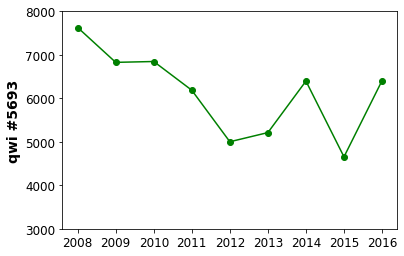

In [ ]:
plt.plot(df_5693['Year'],df_5693['qwi'],'go-',label='qwi')
plt.ylabel("qwi #5693")
plt.ylim(3000,8000)

Well 5693 did not undergo any substantial change. Flow-rate in 2015 was the same as 2013. Maybe well 5769?

# **A closer look at well 5769, the one that got converted**

In [ ]:
df_5769=df_wells_yearly.loc[(df_wells_yearly["NPDCode"].eq(5769))]
df_5769.head(10)

,Year,NPDCode,On Stream,Oil,Gas,Water,WI,WellsType,qo,qw,qg,qwi,ql,rgo,bsw,wor
3,2008.0,5769.0,2678.0,0.0,0.0,0.0,691528.0,injector,0.000000,0.000000,0.000000,6197.412995,0.000000,NaN,NaN,NaN
7,2009.0,5769.0,7562.0,0.0,0.0,0.0,2242719.0,injector,0.000000,0.000000,0.000000,7117.859825,0.000000,NaN,NaN,NaN
11,2010.0,5769.0,7852.0,0.0,0.0,0.0,2303923.0,injector,0.000000,0.000000,0.000000,7042.046867,0.000000,NaN,NaN,NaN
15,2011.0,5769.0,6724.0,0.0,0.0,0.0,1721296.0,injector,0.000000,0.000000,0.000000,6143.828673,0.000000,NaN,NaN,NaN
19,2012.0,5769.0,7057.0,0.0,0.0,0.0,1514295.0,injector,0.000000,0.000000,0.000000,5149.933399,0.000000,NaN,NaN,NaN
23,2013.0,5769.0,7581.0,0.0,0.0,0.0,1788600.0,injector,0.000000,0.000000,0.000000,5662.366442,0.000000,NaN,NaN,NaN
28,2014.0,5769.0,7782.0,0.0,0.0,0.0,1785109.0,injector,0.000000,0.000000,0.000000,5505.347726,0.000000,NaN,NaN,NaN
35,2015.0,5769.0,8364.0,0.0,0.0,0.0,1569314.0,injector,0.000000,0.000000,0.000000,4503.053085,0.000000,NaN,NaN,NaN
42,2016.0,5769.0,5227.0,41160.0,6561826.0,13534.0,472622.0,trans,188.987947,62.141955,30128.912187,2170.064664,251.129902,159.4224,0.247449,0.328814


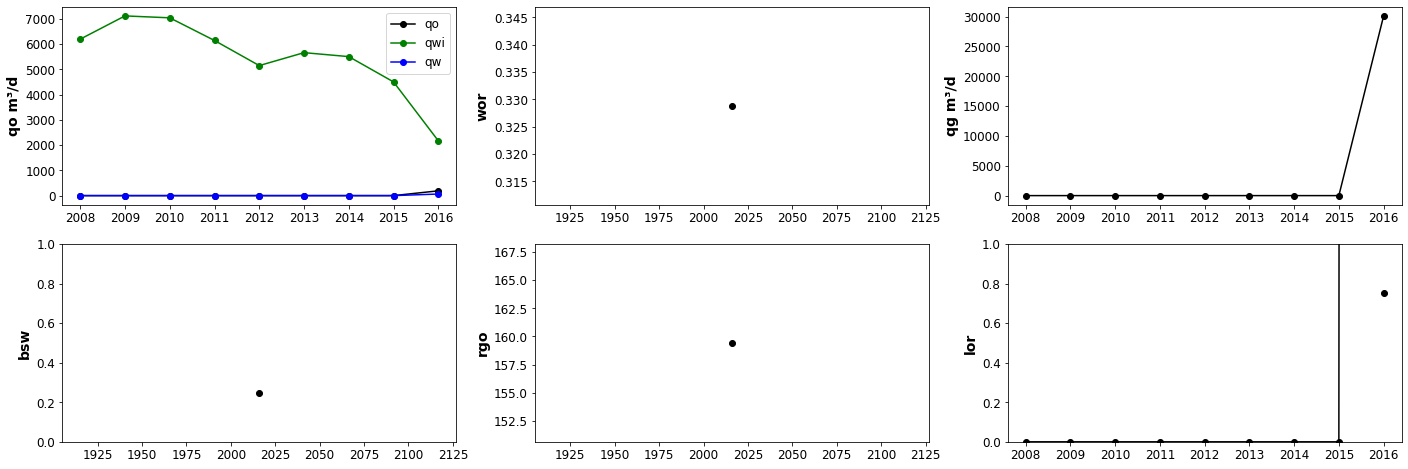

In [ ]:
# let us now create time series plots
labels=['qo','wor','qg','bsw','rgo','ql']
legends=['qo','wor','qg','bsw','rgo','lor']
subplots=(231,232,233,234,235,236)
plt.figure(figsize=(24,8))
for label,subplot,legend in zip(labels,subplots,legends):
  plt.subplot(subplot)
  if subplot==236:
    plt.plot(df_5769['Year'],df_5769['qo']/df_5769[label],'ko-',label=legend)
  if subplot==231:
    plt.plot(df_5769['Year'],df_5769[label],'ko-',label=legend)
    plt.plot(df_5769['Year'],df_5769['qwi'],'go-',label='qwi')
    plt.plot(df_5769['Year'],df_5769['qw'],'bo-',label='qw')
    plt.legend()
  else:  
    plt.plot(df_5769['Year'],df_5769[label],'ko-',label=legend)
  
  if subplot==231 or subplot==233: 
    plt.ylabel(legend+' m³/d')
  else:
    plt.ylabel(legend) 
  if legend=="bsw" or legend=="lor":
    plt.ylim(0,1.0) 

Well 5769 had its injection-rate reduced in 2015.I find it hard to believe this alone caused the produced water rate of 5599 to drop that much.The injection rate in well 5769 went from 6000m³/d in 2008 to 2000 m³/d in the year 2016, the year it got converted. Maybe this was the reason it was picked for conversion. 

Let´s see if we can derive more insights from looking at the monthly time series of each well individually.

In [ ]:
def remove_duplicates(item_list):
    ''' Removes duplicate items from a list '''
    singles_list = []
    for element in item_list:
        if element not in singles_list:
            singles_list.append(element)
    return singles_list

In [ ]:
prod_list=df_wells_yearly["NPDCode"][df_wells_yearly["WellsType"].eq("producer")].tolist()
prod_list=remove_duplicates(prod_list)

In [ ]:
prod_list

[5351.0, 5599.0, 7078.0, 7289.0, 7405.0]

In [ ]:
df_field_monthly=df.groupby(['Year','Month','NPDCode'], as_index=False)['On Stream','Oil','Gas','Water','WI'].sum()
df_field_monthly

,Year,Month,NPDCode,On Stream,Oil,Gas,Water,WI
0,2008.0,2.0,5351.0,0.0,0.0,0.0,0.0,0.0
1,2008.0,2.0,5599.0,407.0,49091.0,7068009.0,413.0,0.0
2,2008.0,3.0,5351.0,0.0,0.0,0.0,0.0,0.0
3,2008.0,3.0,5599.0,655.0,83361.0,12191171.0,27.0,0.0
4,2008.0,3.0,5693.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
502,2016.0,9.0,5599.0,0.0,0.0,0.0,0.0,0.0
503,2016.0,9.0,5693.0,340.0,0.0,0.0,0.0,61201.0
504,2016.0,9.0,5769.0,0.0,0.0,0.0,0.0,0.0
505,2016.0,9.0,7078.0,392.0,8609.0,1458816.0,46779.0,0.0


# **Comparing wells 5351, 5599 and 5769**

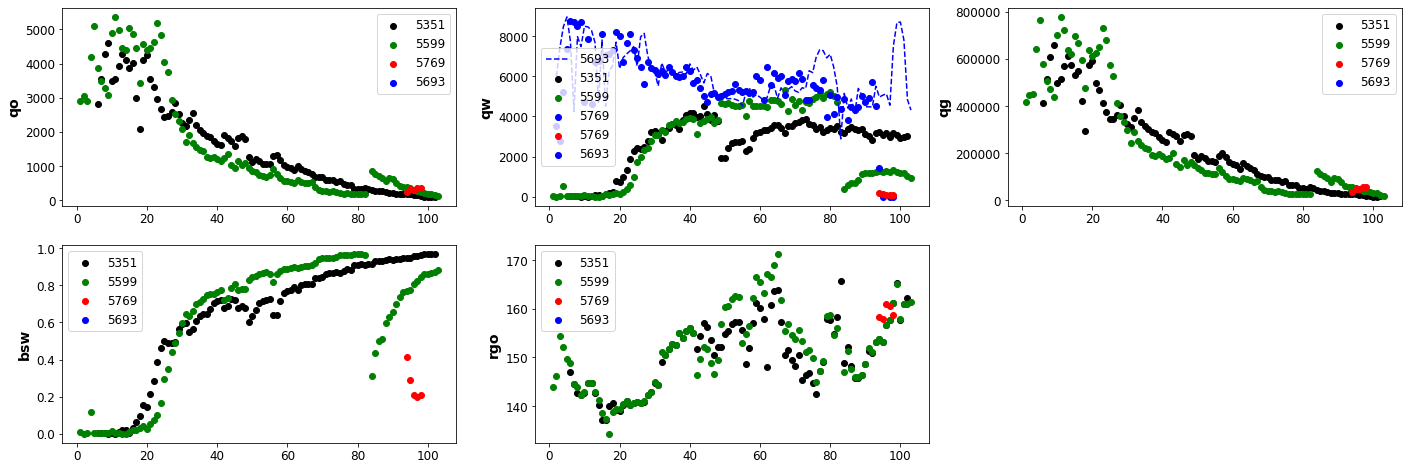

In [ ]:
prod_list=[5351,5599,5769,5693]
plt.figure(figsize=(24,8))
c_wells=['k','g','r','b','b']
for prod,c_well in zip(prod_list,c_wells):
  dframe=df.loc[(df["NPDCode"].eq(prod))]
  n_rows=dframe.shape[0]
  months=np.arange(1,n_rows+1)
  dframe['t_months']=months
  labels=['qo','qw','qg','bsw','rgo']
  legends=['qo','qw','qg','bsw','rgo']
  subplots=(231,232,233,234,235)
  for label,subplot in zip(labels,subplots):
    plt.subplot(subplot)
    if prod==5769 and subplot==232:
      plt.scatter(dframe.t_months,dframe['qwi'],c='b',label=prod)
    if prod==5693 and subplot==232:
      plt.plot(dframe.t_months,dframe['qwi'],'b--',label=prod)
    plt.scatter(dframe.t_months,dframe[label],c=c_well,label=prod)
    plt.legend()
    plt.ylabel(label)


Here we are looking at the 4 initial wells: 2P (5351,5599) and 2I(5769,5693). 
*   Both producers behave very much in tandem relative to qo, rgo and qg. 
*   This is probably a small oil field, and 5351 and 5599 are both draining the same portion and are hydraulically connected. They show the same oil-decline rate and there must be a fairly high degree of areal homogeneity between those 2 producers.
*   Looking at the injectors 5693 and 5769 (that got converted later on), we also notice their injection rates are also quite similar. The same observations made on the producers also apply here.
*   Moreover, when 5769 gets converted into a producer, its initial oil-rate is the same rate produced by 5351 and 5599, and the same goes for its RGO. These observations allow us to conjecture that these 4 wells are all hydraulically connected.
*   The porous medium shows a very small degree of heterogeneity.
*   The drop in BSW in well 5599 was probably due to a high BSW zone being shut-off.
*   As for the decline in injection rates: the operators probably intentionally reduced it so that water production wouldn´t grow too fast, or there might be some scaling being responsible for impairing the water injectivity.

# **Comparing wells 7078, 7289 and 7405**

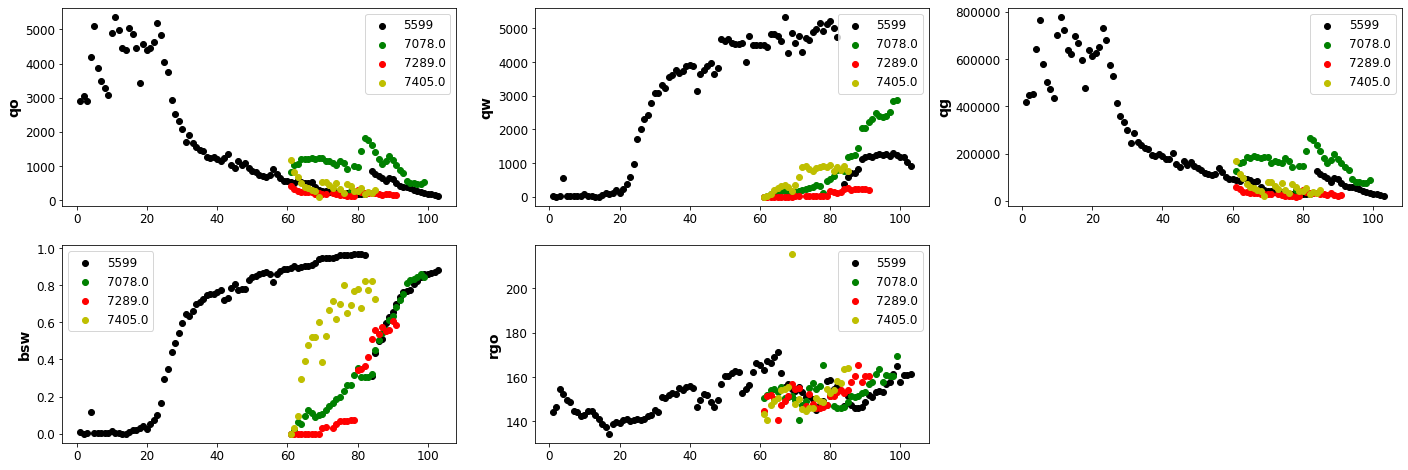

In [ ]:
prod_list=[5599,7078.0, 7289.0, 7405.0]
plt.figure(figsize=(24,8))
c_wells=['k','g','r','y','b']
for prod,c_well in zip(prod_list,c_wells):
  dframe=df.loc[(df["NPDCode"].eq(prod))]
  n_rows=dframe.shape[0]
  months=np.arange(1,n_rows+1)
  dframe['t_months']=months
  labels=['qo','qw','qg','bsw','rgo']
  legends=['qo','qw','qg','bsw','rgo']
  subplots=(231,232,233,234,235)
  for label,subplot in zip(labels,subplots):
    plt.subplot(subplot)
    if prod != 5599:
      plt.scatter(dframe.t_months+60,dframe[label],c=c_well,label=prod)  
    else:
      plt.scatter(dframe.t_months,dframe[label],c=c_well,label=prod)
    plt.legend()
    plt.ylabel(label)

These are the new wells added in 2013. These wells were certainly not drilled in a separate compartment. As already mentioned, the heterogeneity is fairly low. And this set of plots only add to that observation. The new wells´s initial flow-rate is close to well 5599. Except for well 7078, which comes on with a slightly higher rate.